In [97]:
# Comparing RO to INS data

import sys
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts")
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts/config")
from figs import plot
import motion

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
# import pandas as pd
import os
from numpy import *

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# text
plt.rc("text", usetex=True)
plt.rc("font", family=settings.FONT_FAMILY)

import module
import settings

module.set_sys_paths()

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

import numpy as np
from config.data import *

In [98]:
# INS_relative_poses_path = "/private/tmp/flattened_novatel_generated_poses.monolithic"
# RO_relative_poses_path = 
INS_relative_poses_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/dataset-name/motion_estimation/2018-06-21-16-24-39-long-hanborough-to-ori-V4-radar-leopon-trial-sunny-long-range/ground-truth/flattened_novatel_generated_poses.monolithic"
RO_relative_poses_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/dataset-name/motion_estimation/2018-06-21-16-24-39-long-hanborough-to-ori-V4-radar-leopon-trial-sunny-long-range/standard-ro/radar_motion_estimation.monolithic"

# INS - open monolithic and iterate frames
print("reading INS_relative_poses_path: " + INS_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    INS_relative_poses_path)

# iterate mono
INS_se3s = []
INS_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    INS_se3s.append(serialised_transform[0])
    INS_timestamps.append(serialised_transform[1])
    
# RO - open monolithic and iterate frames
print("reading RO_relative_poses_path: " + RO_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    RO_relative_poses_path)

# iterate mono
RO_se3s = []
RO_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    RO_se3s.append(serialised_transform[0])
    RO_timestamps.append(serialised_transform[1])

reading INS_relative_poses_path: /Users/roberto/data/odometry-comparisons/rugged_ro/dataset-name/motion_estimation/2018-06-21-16-24-39-long-hanborough-to-ori-V4-radar-leopon-trial-sunny-long-range/ground-truth/flattened_novatel_generated_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
reading RO_relative_poses_path: /Users/roberto/data/odometry-comparisons/rugged_ro/dataset-name/motion_estimation/2018-06-21-16-24-39-long-hanborough-to-ori-V4-radar-leopon-trial-sunny-long-range/standard-ro/radar_motion_estimation.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2


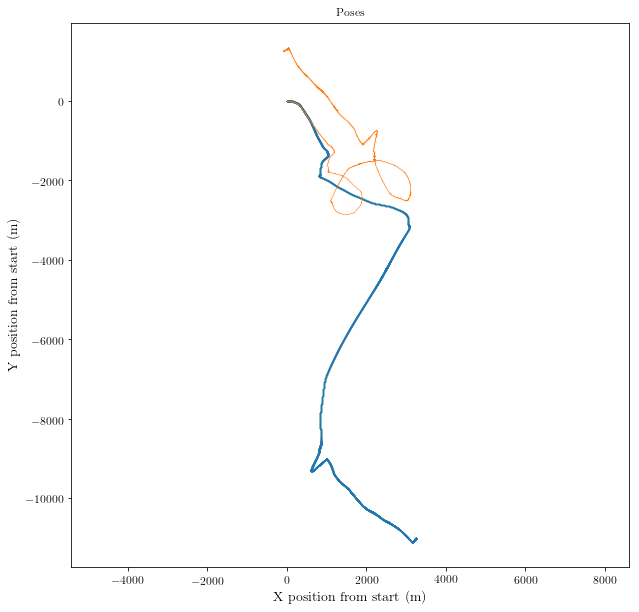

In [99]:
# get INS poses
INS_poses = []
pose = np.identity(4)
for i in range(len(INS_se3s)):
    pose = pose * INS_se3s[i]
    INS_poses.append(pose)

# get x,y coords
x_INS = [pose[0, 3] for pose in INS_poses]
y_INS = [pose[1, 3] for pose in INS_poses]

# get RO poses
RO_poses = []
pose = np.identity(4)
for i in range(len(RO_se3s)):
    pose = pose * RO_se3s[i]
    RO_poses.append(pose)

# get x,y coords
x_RO = [pose[0, 3] for pose in RO_poses]
y_RO = [pose[1, 3] for pose in RO_poses]

plt.figure(figsize=(10,10))
plt.plot(x_INS,y_INS,'.',markersize=0.1);
plt.plot(x_RO,y_RO,'.',markersize=0.1);
plt.axis('equal');
plt.title('Poses');
plt.xlabel('X position from start (m)');
plt.ylabel('Y position from start (m)');

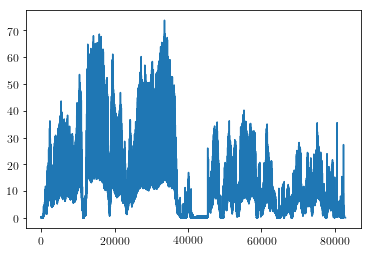

In [100]:
# get INS speeds
assert len(INS_se3s) == len(INS_timestamps)
INS_speeds = []
INS_TIMESTAMPS = []
deltatime_arr = []
for i in range(len(INS_timestamps) - 1):
# for i in range(0,len(timestamps) - 1,10): # this fixed the glitches by skipping them
# for i in range(1000,2000):
    # work out speed
    delta_time = INS_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION \
        - INS_timestamps[i] / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = INS_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    INS_speeds.append(speed)
    INS_TIMESTAMPS.append(INS_timestamps[i])
plt.plot(INS_speeds);

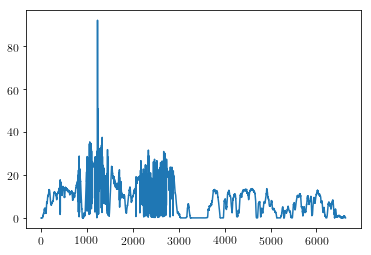

In [101]:
# get speeds
assert len(RO_se3s) == len(RO_timestamps)
RO_speeds = []
RO_TIMESTAMPS = []
deltatime_arr = []
for i in range(len(RO_timestamps) - 1):
# for i in range(0,len(timestamps) - 1,10): # this fixed the glitches by skipping them
# for i in range(1000,2000):
    # work out speed
    delta_time = RO_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION \
        - RO_timestamps[i] / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = RO_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    RO_speeds.append(speed)
    RO_TIMESTAMPS.append(RO_timestamps[i])
plt.plot(RO_speeds);

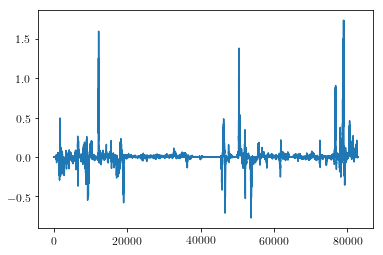

In [102]:
# INS yaw rates
assert len(INS_se3s) == len(INS_timestamps)
INS_yaw_rates = []
INS_TIMESTAMPS = []
for i in range(len(INS_timestamps) - 1):
    # work out yaw_rate
    delta_time = INS_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION  \
        - INS_timestamps[i] / settings.TIMESTAMP_CONVERSION
    se3 = INS_se3s[i]
    xyzrpy = se3_to_components(se3)
    yaw_rate = xyzrpy[-1] / delta_time
    INS_yaw_rates.append(yaw_rate)
    INS_TIMESTAMPS.append(INS_timestamps[i])
plt.plot(INS_yaw_rates)

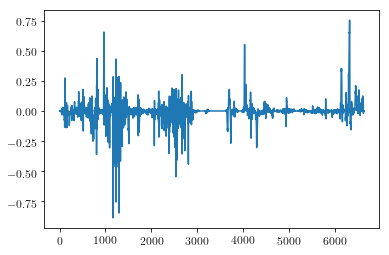

In [103]:
# RO yaw rates
assert len(RO_se3s) == len(RO_timestamps)
RO_yaw_rates = []
RO_TIMESTAMPS = []
for i in range(len(RO_timestamps) - 1):
    # work out yaw_rate
    delta_time = RO_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION  \
        - RO_timestamps[i] / settings.TIMESTAMP_CONVERSION
    se3 = RO_se3s[i]
    xyzrpy = se3_to_components(se3)
    yaw_rate = xyzrpy[-1] / delta_time
    RO_yaw_rates.append(yaw_rate)
    RO_TIMESTAMPS.append(RO_timestamps[i])
plt.plot(RO_yaw_rates)

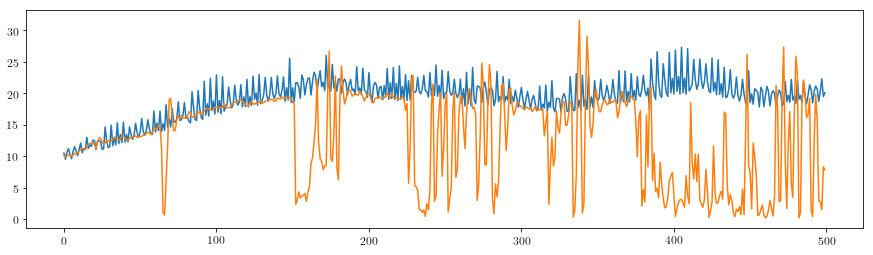

In [104]:
# Do interpolation (accumulatation for now)
interp_INS_speed = []
distance = 0
temp_speed = 0
j = 0
for i in range(len(RO_timestamps)):
    while(INS_timestamps[j] < RO_timestamps[i]):
        distance += INS_speeds[j]*(INS_timestamps[j]-INS_timestamps[j-1])
        j+=1
    temp_speed = distance/(RO_timestamps[i]-RO_timestamps[i-1])
    interp_INS_speed.append(temp_speed)
    distance = 0
plt.figure(figsize=(15,4))
plt.plot(interp_INS_speed[2000:2500])
plt.plot(RO_speeds[2000:2500])

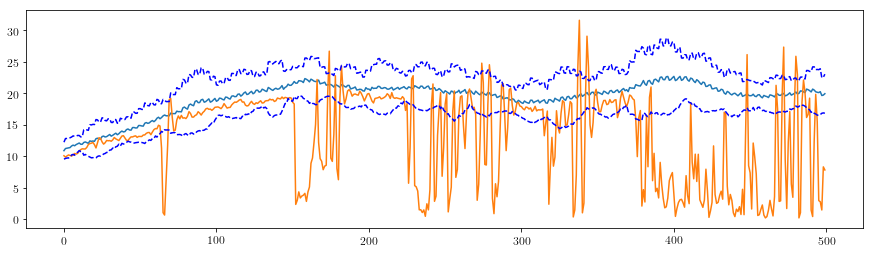

In [105]:
window_size = 10
std_devs = []
means = []
for i in range(window_size//2,len(interp_INS_speed)-window_size//2):
    window_contents = interp_INS_speed[i-window_size//2:i+window_size//2]
    std_devs.append(std(window_contents))
    means.append(mean(window_contents))
    
means = np.array(means)
std_devs = np.array(std_devs)
plt.figure(figsize=(15,4))
plt.plot(means[2005:2505])
plt.plot(RO_speeds[2000:2500])
plt.plot(means[2005:2505]+2*std_devs[2005:2505],'b--')
plt.plot(means[2005:2505]-2*std_devs[2005:2505],'b--')

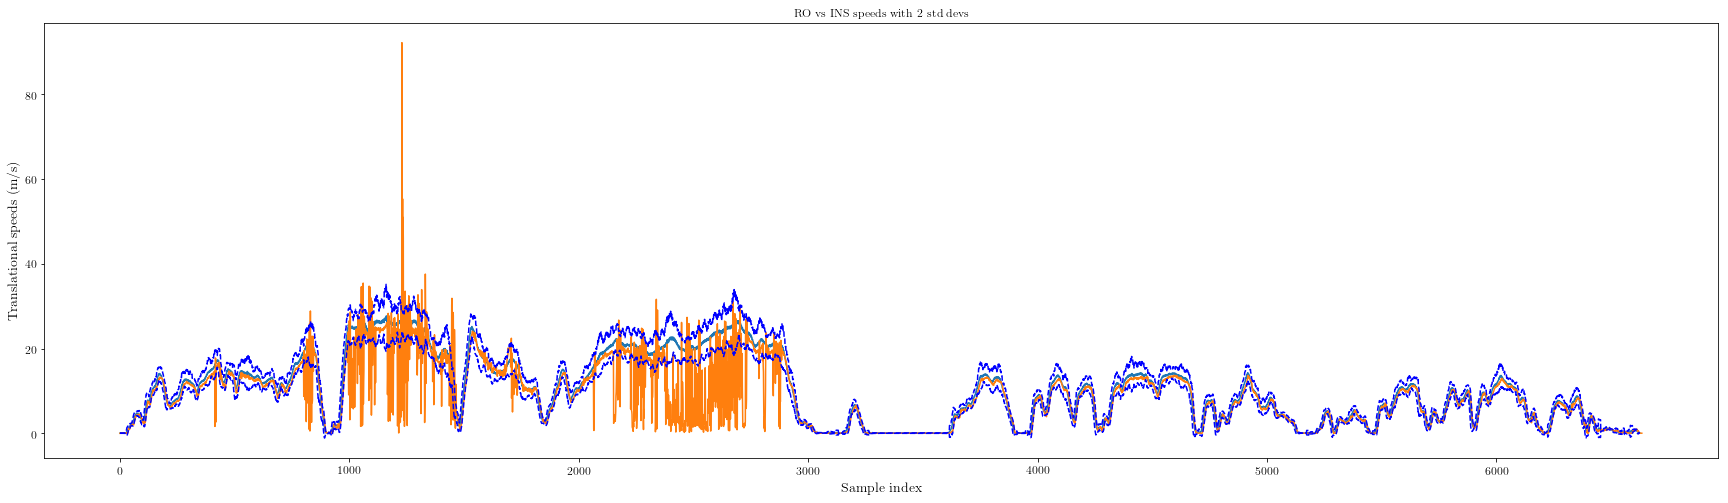

In [106]:
plt.figure(figsize=(30,8))
plt.title('RO vs INS speeds with 2 std devs')
plt.ylabel('Translational speeds (m/s)')
plt.xlabel('Sample index')
plt.plot(means)
plt.plot(RO_speeds)
plt.plot(means+2*std_devs,'b--')
plt.plot(means-2*std_devs,'b--')
# plt.plot(means+3*std_devs,'k--')
# plt.plot(means-3*std_devs,'k--')

In [107]:
# Checking for failures based on speeds (not accelerations)
m = len(means)
upper_thresh = means + 2*std_devs
lower_thresh = means - 2*std_devs
classification = zeros(m)
for i in range(m):
    if(RO_speeds[i] < lower_thresh[i]) or RO_speeds[i] > upper_thresh[i]:
        classification[i] = 1;
    

Detected failures: 885 of 6626 samples


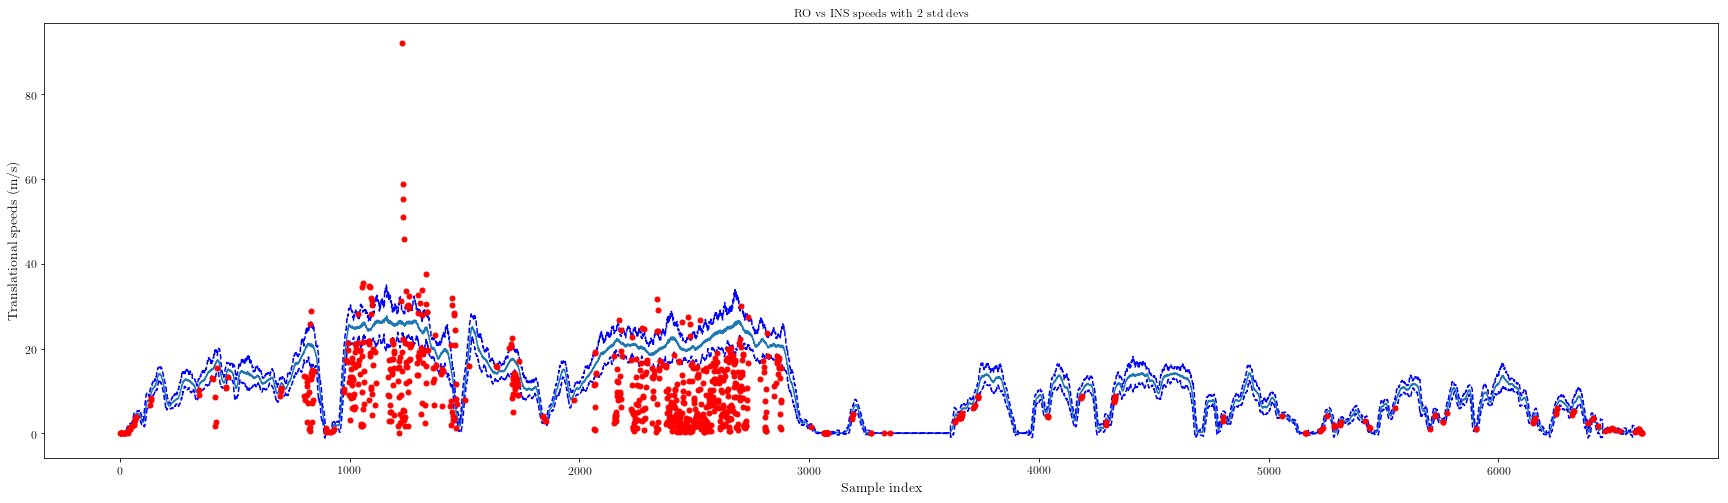

In [108]:
plt.figure(figsize=(30,8))
plt.title('RO vs INS speeds with 2 std devs')
plt.ylabel('Translational speeds (m/s)')
plt.xlabel('Sample index')
plt.plot(means)
plt.plot(means+2*std_devs,'b--')
plt.plot(means-2*std_devs,'b--')
for i in range(m):
    if(classification[i] == 1):
        plt.plot(i,RO_speeds[i],'r.-',markersize=10)
#     else:
# plt.plot(RO_speeds,'g.-',markersize=1) 

tally = 0;
for i in range(m):
    if(classification[i] == 1):
        tally+=1
print('Detected failures:',tally,"of",m,'samples')

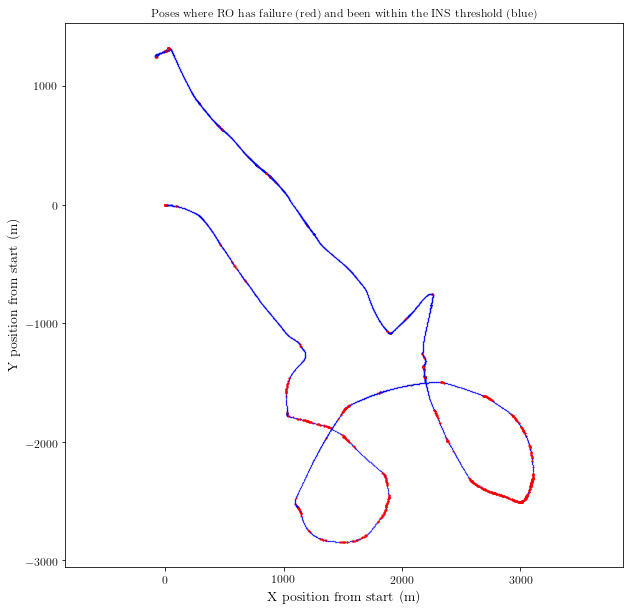

In [109]:
plt.figure(figsize=(10,10))
for i in range(m):
    if(classification[i] == 1):
        plt.plot(x_RO[i],y_RO[i],'r.',markersize=2);
    else:
        plt.plot(x_RO[i],y_RO[i],'b.',markersize=0.5);

plt.axis('equal');
plt.title('Poses where RO has failure (red) and been within the INS threshold (blue)');
plt.xlabel('X position from start (m)');
plt.ylabel('Y position from start (m)');

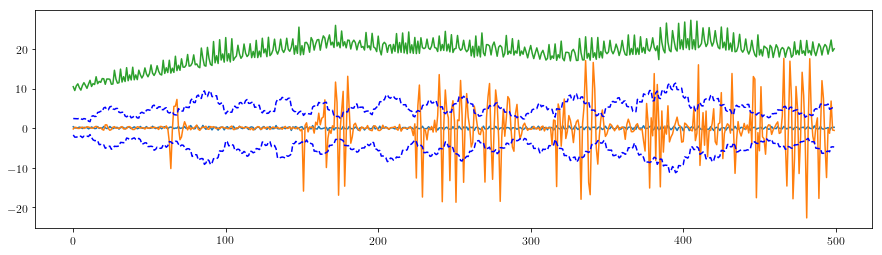

In [110]:
RO_accs = diff(RO_speeds)
interp_INS_accs = diff(interp_INS_speed)
means_acc = []
std_devs_acc = []
window_size = 10
for i in range(window_size//2,len(interp_INS_accs)-window_size//2):
    window_contents = interp_INS_accs[i-window_size//2:i+window_size//2]
    std_devs_acc.append(std(window_contents))
    means_acc.append(mean(window_contents))
    
means_acc = np.array(means_acc)
std_devs_acc = np.array(std_devs_acc)
plt.figure(figsize=(15,4))
plt.plot(means_acc[2005:2505])
plt.plot(RO_accs[2000:2500])
plt.plot(means_acc[2005:2505]+2*std_devs_acc[2005:2505],'b--')
plt.plot(means_acc[2005:2505]-2*std_devs_acc[2005:2505],'b--')
plt.plot(interp_INS_speed[2000:2500])


# plt.figure(figsize=(30,8))
# plt.title('RO vs INS accelerations')
# plt.ylabel('Translational speeds (m/s)')
# plt.xlabel('Sample index')
# plt.ylim(-3,3)
# plt.plot(means_acc[2000:2500])
# plt.plot(RO_accs[2000:2500])
# plt.plot(diff(means[2000:2200]+2*std_devs[2000:2200]),'b--')
# plt.plot(diff(means[2000:2200]-2*std_devs[2000:2200]),'b--')
# plt.plot(means+3*std_devs,'k--')
# plt.plot(means-3*std_devs,'k--')

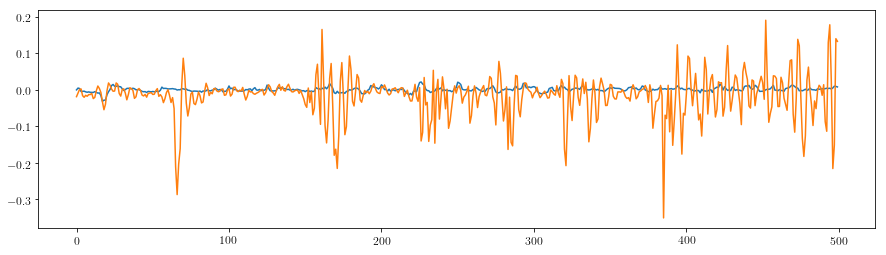

In [111]:
# Failures due to yaw rate
interp_INS_yaw = []
angle = 0
temp_angle = 0
j = 0
for i in range(len(RO_timestamps)):
    while(INS_timestamps[j] < RO_timestamps[i]):
        angle += INS_yaw_rates[j]*(INS_timestamps[j]-INS_timestamps[j-1])
        j+=1
    temp_angle = angle/(RO_timestamps[i]-RO_timestamps[i-1])
    interp_INS_yaw.append(temp_angle)
    angle = 0
plt.figure(figsize=(15,4))
plt.plot(interp_INS_yaw[2000:2500])
plt.plot(RO_yaw_rates[2000:2500])

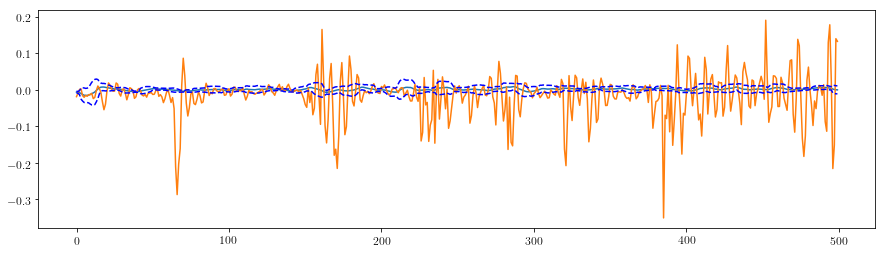

In [112]:
window_size = 10
std_devs = []
means = []
for i in range(window_size//2,len(interp_INS_yaw)-window_size//2):
    window_contents = interp_INS_yaw[i-window_size//2:i+window_size//2]
    std_devs.append(std(window_contents))
    means.append(mean(window_contents))
    
means = np.array(means)
std_devs = np.array(std_devs)
plt.figure(figsize=(15,4))
plt.plot(means[2005:2505])
plt.plot(RO_yaw_rates[2000:2500])
plt.plot(means[2005:2505]+2*std_devs[2005:2505],'b--')
plt.plot(means[2005:2505]-2*std_devs[2005:2505],'b--')

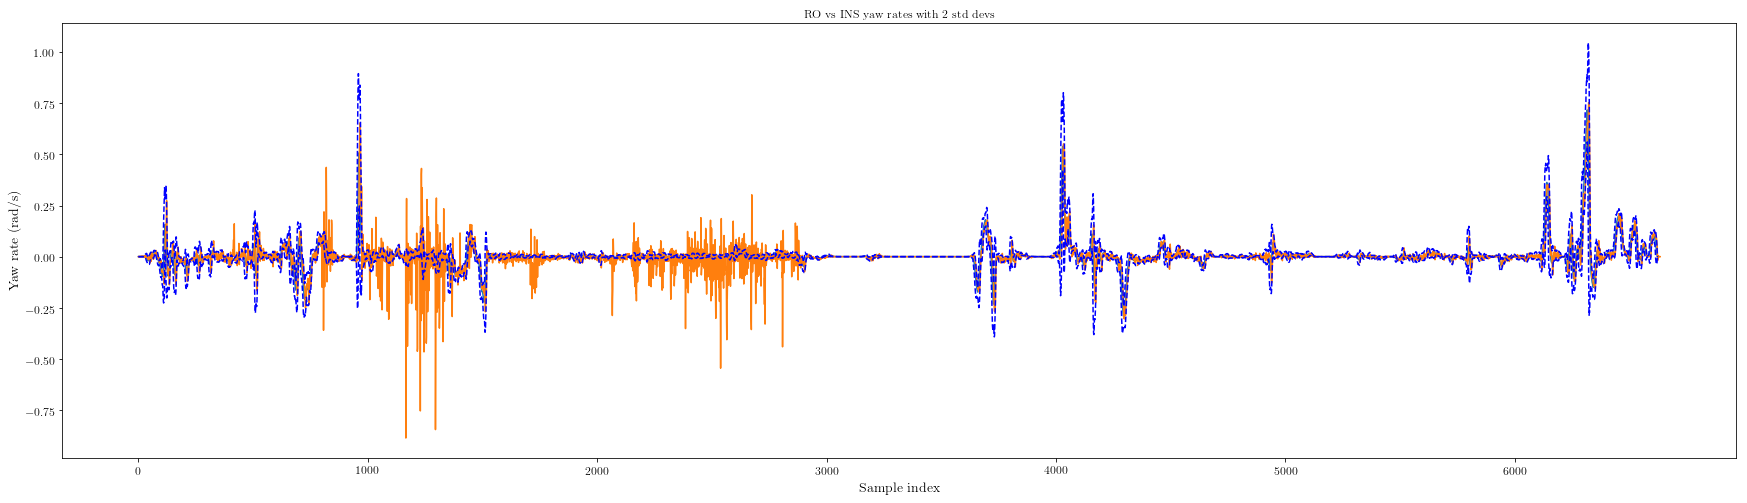

In [113]:
plt.figure(figsize=(30,8))
plt.title('RO vs INS yaw rates with 2 std devs')
plt.ylabel('Yaw rate (rad/s)')
plt.xlabel('Sample index')
plt.plot(means)
plt.plot(RO_yaw_rates)
plt.plot(means+2*std_devs,'b--')
plt.plot(means-2*std_devs,'b--')

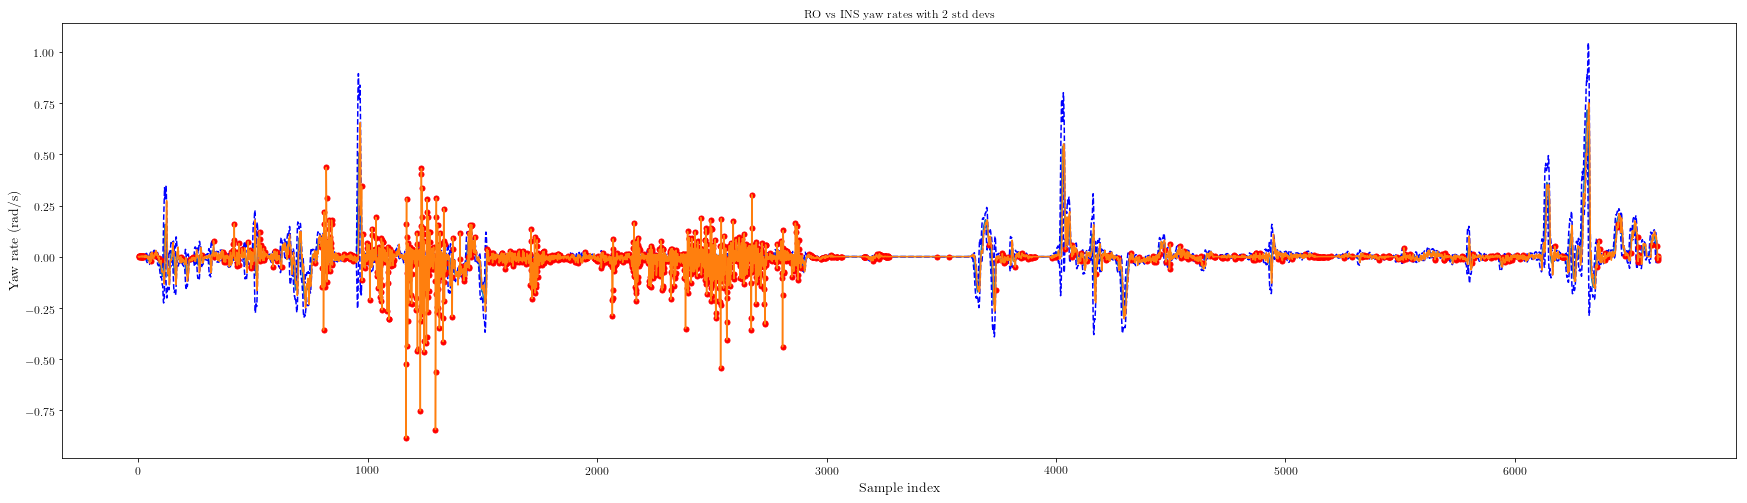

In [115]:
# Checking for failures based on yaw rates
m = len(means)
# max_tolerance = 0.2
upper_thresh = means + 3*std_devs
lower_thresh = means - 3*std_devs
classification = zeros(m)
for i in range(m):
    if(RO_yaw_rates[i] < lower_thresh[i]) or RO_yaw_rates[i] > upper_thresh[i]:
        classification[i] = 1;

plt.figure(figsize=(30,8))
plt.title('RO vs INS yaw rates with 2 std devs')
plt.ylabel('Yaw rate (rad/s)')
plt.xlabel('Sample index')
plt.plot(means)
plt.plot(means+2*std_devs,'b--')
plt.plot(means-2*std_devs,'b--')
for i in range(m):
    if(classification[i] == 1):
        plt.plot(i,RO_yaw_rates[i],'r.-',markersize=10)
plt.plot(RO_yaw_rates)